# Linear Quantization I: Get the Scale and Zero Point

Learn about fundamentals of linear quantization, and implement your own Linear Quantizer.

In [1]:
import torch

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()


########## Functions from Linear Quantization I (Part 1)
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype = torch.int8):
    scaled_and_shifted_tensor = tensor / scale + zero_point
    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    
    return q_tensor


def linear_dequantization(quantized_tensor, scale, zero_point):
    return scale * (quantized_tensor.float() - zero_point)

#############


### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

## Finding `Scale` and `Zero Point` for Quantization

In [2]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [3]:
q_min

-128

In [4]:
q_max

127

In [5]:
# r_min = test_tensor.min()
r_min = test_tensor.min().item()

In [6]:
r_min

-184.0

In [7]:
r_max = test_tensor.max().item()

In [8]:
r_max

728.5999755859375

In [9]:
scale = (r_max - r_min) / (q_max - q_min)

In [10]:
scale

3.578823433670343

In [11]:
zero_point = q_min - (r_min / scale)

In [12]:
zero_point

-76.58645490333825

In [13]:
zero_point = int(round(zero_point))

In [14]:
zero_point

-77

- Now, put all of this in a function.

In [15]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)

    zero_point = q_min - (r_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    
    return scale, zero_point

- Test the implementation using the `test_tensor` defined earlier.
```Python
[[191.6, -13.5, 728.6],
 [92.14, 295.5,  -184],
 [0,     684.6, 245.5]]
```

In [16]:
new_scale, new_zero_point = get_q_scale_and_zero_point(
    test_tensor)

In [17]:
new_scale

3.578823433670343

In [18]:
new_zero_point

-77

## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

- Use the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [19]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, new_scale, new_zero_point)

In [20]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           new_scale, new_zero_point)

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

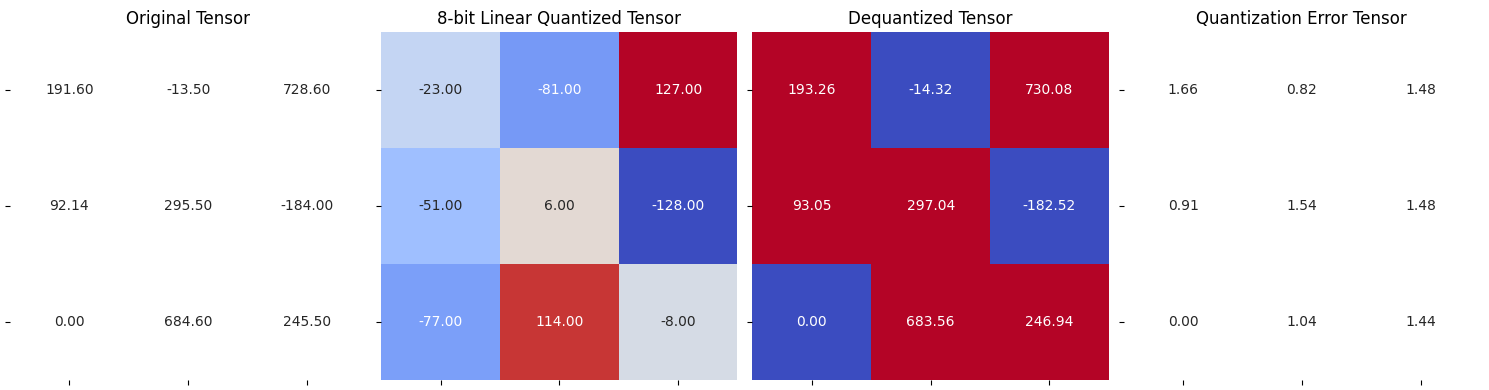

In [21]:
plot_quantization_errors(test_tensor, quantized_tensor, 
                         dequantized_tensor)

In [22]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [23]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, 
                                                   dtype=dtype)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                          scale, 
                                                          zero_point, 
                                                          dtype=dtype)
    
    return quantized_tensor, scale , zero_point

- Test your implementation on a random matrix.

In [24]:
r_tensor = torch.randn((4, 4))

**Note:** Since the values are random, what you see in the video might be different than what you will get.

In [25]:
r_tensor

tensor([[ 2.0079,  0.6456, -0.8363,  0.2700],
        [-1.4321,  1.0076, -0.4744, -0.3639],
        [ 0.0539,  1.2317,  0.2359, -0.9502],
        [-0.9531, -0.1586,  0.5949,  2.3460]])

In [26]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [27]:
quantized_tensor

tensor([[ 105,   13,  -87,  -13],
        [-128,   37,  -63,  -56],
        [ -27,   52,  -15,  -95],
        [ -95,  -42,    9,  127]], dtype=torch.int8)

In [28]:
scale

0.01481630147672167

In [29]:
zero_point

-31

In [30]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           scale, zero_point)

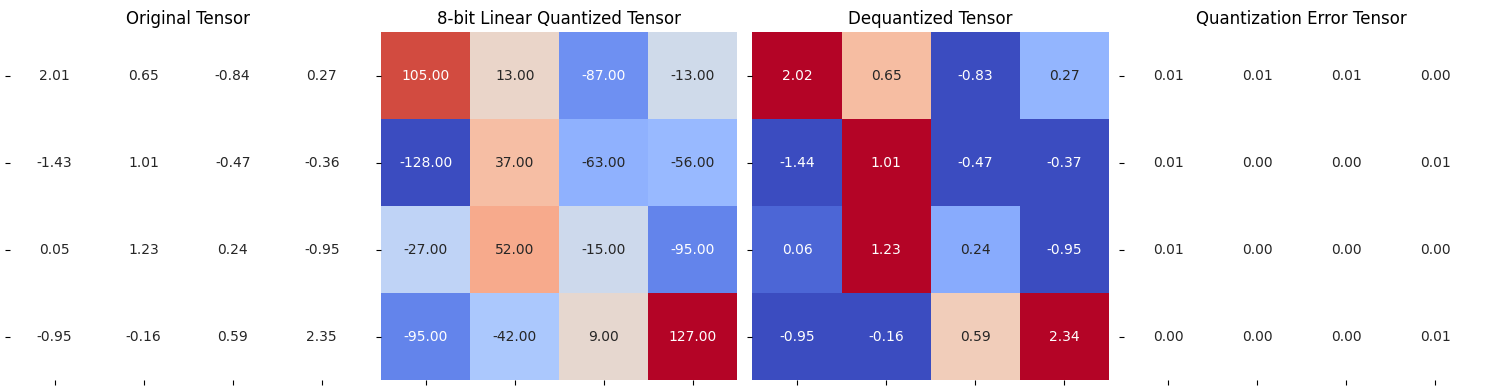

In [31]:
plot_quantization_errors(r_tensor, quantized_tensor,
                         dequantized_tensor)

In [32]:
(dequantized_tensor-r_tensor).square().mean()

tensor(2.0347e-05)